In [6]:
import os.path as osp

import numpy as np
import pandas as pd
import torch
# from sentence_transformers import SentenceTransformer

from torch_geometric.data import HeteroData, download_url, extract_zip
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import TSNE

In [7]:
import os.path as osp

import torch
import torch.nn as nn

# from torch_geometric.datasets import Planetoid
from torch_geometric.nn import DeepGraphInfomax, GCNConv

In [8]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from bhtsne import tsne

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
def visualize2(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [9]:
root = '../data/'

In [10]:
class DomainsDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(DomainsDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return [osp.join(root, "processed/G_domain.data")]

    def download(self):
        pass
    
    def process(self):
        
        df = pd.read_csv(osp.join(root, "original/domainGraph_ids.csv"))
        
        data_list = []

        node_ids = set(df['src_id']).union(df['trg_id'])
        src_ids = df['src_id']
        trg_ids = df['trg_id']

        x = torch.tensor([[c] for c in node_ids], dtype=torch.float)
#         y = torch.tensor([0]*len(node_ids), dtype=torch.float)
#         edge_attr = torch.from_numpy(df['score'].to_numpy(np.float32)) #extract the features from the dataset.
#         edge_attr = (edge_attr - edge_attr.mean(axis=0)) / (edge_attr.std(axis=0))

        edge_index = torch.tensor([src_ids,
                                   trg_ids], dtype=torch.long)


        data = Data(x=x, edge_index=edge_index)

        data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [12]:
dataset = DomainsDataset('../')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DomainsDataset():
Number of graphs: 1
Number of features: 1
Number of classes: 0

Data(x=[269, 1], edge_index=[2, 25542])
Number of nodes: 269
Number of edges: 25542
Average node degree: 94.95
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [16]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, hidden_channels, cached=True)
        self.prelu = nn.PReLU(hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.prelu(x)
        return x


def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepGraphInfomax(
    hidden_channels=64, encoder=Encoder(dataset.num_features, 64),
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.eval()

out, _, _  = model(data.x, data.edge_index)

In [18]:
out.shape

torch.Size([269, 64])

/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


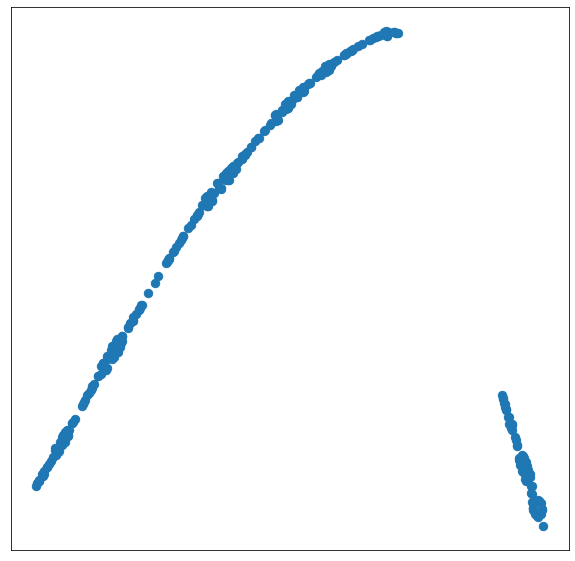

In [19]:
visualize(out, color=data.y)

# Connect with domains

In [23]:
res = pd.DataFrame(out.detach().cpu().numpy())
res

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,-16.909233,40.896397,26.920692,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112
1,-16.952030,74.914536,23.953018,-23.373148,-9.075496,87.457550,21.197077,46.538441,83.537483,12.412493,...,-21.036055,50.877441,33.490883,28.486929,-12.062867,-18.870287,-7.859801,62.061501,2.511930,13.906214
2,-14.501533,64.085289,20.490496,-19.994442,-7.763587,74.815170,18.132929,39.811085,71.461746,10.618206,...,-17.995188,43.522858,28.649611,24.369005,-10.319120,-16.142492,-6.723625,53.090225,2.148817,11.896001
3,-11.967712,52.887817,16.910234,-16.500860,-6.407076,61.742870,14.964602,32.854988,58.975418,8.762913,...,-14.850929,35.918221,23.643728,20.111065,-8.516084,-13.321952,-5.548821,43.813889,1.773360,9.817441
4,-16.197344,71.579422,22.886656,-22.332602,-8.671467,83.564041,20.253395,44.466599,79.818527,11.859902,...,-20.099554,48.612473,31.999899,27.218725,-11.525839,-18.030199,-7.509891,59.298618,2.400101,13.287121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,-5.235421,23.136415,7.397589,-7.218501,-2.802853,27.010166,6.546447,14.372811,25.799511,3.833443,...,-6.496718,15.712860,10.343239,8.797831,-3.725464,-5.827848,-2.427399,19.166916,0.775778,4.294758
265,-4.395596,19.425051,6.210925,-6.060565,-2.353241,22.677410,5.496317,12.067238,21.660955,3.218510,...,-5.454566,13.192325,8.684054,7.386549,-3.127854,-4.892990,-2.038015,16.092308,0.651334,3.605826
266,-2.079659,9.190447,2.938534,-2.867395,-1.113373,10.729212,2.600436,5.709291,10.248303,1.522753,...,-2.580683,6.241598,4.108630,3.494750,-1.479861,-2.314988,-0.964232,7.613647,0.308161,1.706001
267,-1.801462,7.961037,2.545445,-2.483822,-0.964437,9.293961,2.252575,4.945557,8.877382,1.319053,...,-2.235464,5.406656,3.559017,3.027256,-1.281899,-2.005311,-0.835247,6.595166,0.266938,1.477788


In [25]:
domain_data = pd.read_csv(osp.join(root, "original/master.csv"))
domain_data = domain_data[['domain_id', 'country_id', 'bias_id', 'factual_id']]
domain_data = domain_data.set_index("domain_id")

In [26]:
out_colored = res.join(domain_data)
out_colored

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,country_id,bias_id,factual_id
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112,0.0,0.0,0.0
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112,0.0,0.0,0.0
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112,0.0,0.0,0.0
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112,0.0,0.0,0.0
0,-13.626412,60.217937,19.253952,-18.787838,-7.295080,70.300293,17.038660,37.408600,67.149254,9.977431,...,22.898413,-9.696394,-15.168340,-6.317874,49.886383,2.019143,11.178112,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,-5.235421,23.136415,7.397589,-7.218501,-2.802853,27.010166,6.546447,14.372811,25.799511,3.833443,...,8.797831,-3.725464,-5.827848,-2.427399,19.166916,0.775778,4.294758,NaN,NaN,NaN
265,-4.395596,19.425051,6.210925,-6.060565,-2.353241,22.677410,5.496317,12.067238,21.660955,3.218510,...,7.386549,-3.127854,-4.892990,-2.038015,16.092308,0.651334,3.605826,NaN,NaN,NaN
266,-2.079659,9.190447,2.938534,-2.867395,-1.113373,10.729212,2.600436,5.709291,10.248303,1.522753,...,3.494750,-1.479861,-2.314988,-0.964232,7.613647,0.308161,1.706001,NaN,NaN,NaN
267,-1.801462,7.961037,2.545445,-2.483822,-0.964437,9.293961,2.252575,4.945557,8.877382,1.319053,...,3.027256,-1.281899,-2.005311,-0.835247,6.595166,0.266938,1.477788,NaN,NaN,NaN


In [27]:
item_encoder = LabelEncoder()

In [29]:
# out_colored=out_colored.dropna()

/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


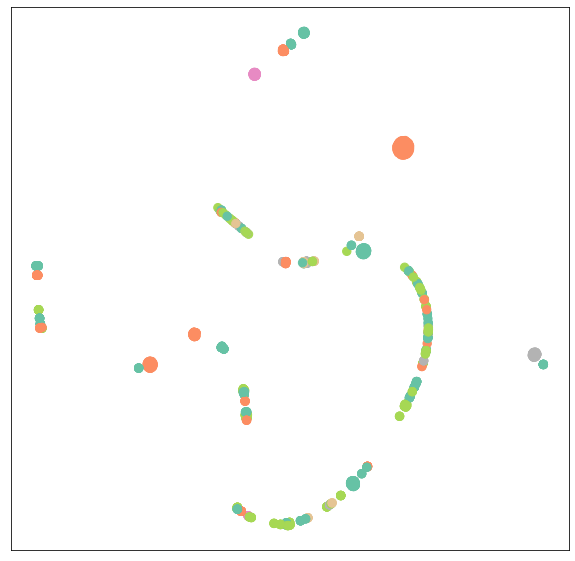

In [30]:
visualize2(out_colored[range(16)], color=out_colored.factual_id)

/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


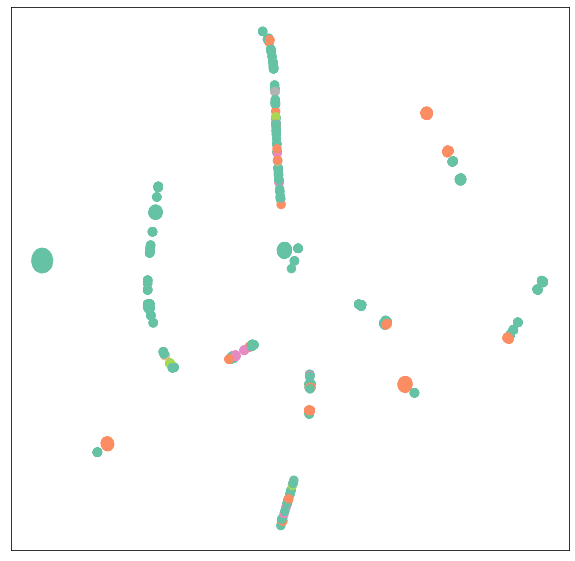

In [31]:
visualize2(out_colored[range(16)], color=out_colored.bias_id)

/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sanja7s/mambaforge/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


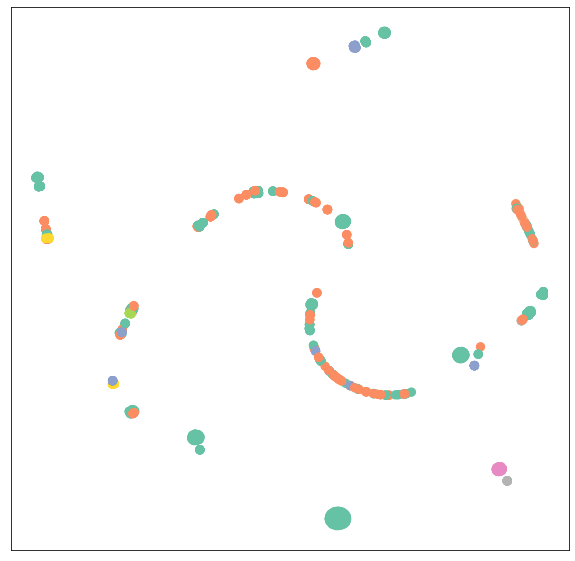

In [32]:
visualize2(out_colored[range(16)], color=out_colored.country_id)